## Creating the training dataset from the equilibria dataset

In [1]:
import os
# os.environ["CUDA_VISIBLE_DEVICES"]="-1"
import numpy as np
import matplotlib.pyplot as plt
from scipy import io
import seaborn as sns
sns.set_style("darkgrid")
from tqdm import tqdm
from matplotlib import cm
from os.path import join, exists
from utils import resample_on_new_subgrid, interp_fun, get_box_from_grid, sample_random_subgrid, calc_laplace_df_dr_ker

In [2]:
# hyperparameters
DTYPE = 'float32'
DATA_DIR = "data" # where the data is stored
full_ds_mat_path = join(DATA_DIR, 'ITER_like_equilibrium_dataset.mat')
sample_ds_mat_path = join(DATA_DIR, 'ITER_like_equilibrium_dataset_sample.mat')

## Loading input data

In [3]:
# # download datasets from gdrive, # uncomment if you want to download the dataset
# import gdown
# gdown.download(id="1-5KP7_OYIvDD_QXvIr5sDihVxZx1qJCN", output=full_ds_mat_path, quiet=False)
# gdown.download(id="1Gn_OrMzxPRkTk-i77--HiWmWZyd8i8ue", output=sample_ds_mat_path, quiet=False)

In [4]:
# remove all files and dirs in the data directory except for full_ds_mat_path and sample_ds_mat_path
if not exists(DATA_DIR): os.makedirs(DATA_DIR) # create data directory 
for file_or_dir in os.listdir(DATA_DIR):
    fn = os.path.join(DATA_DIR, file_or_dir)
    if os.path.isfile(fn) and fn not in [full_ds_mat_path, sample_ds_mat_path]: os.remove(fn)
    elif os.path.isdir(fn): 
        for root, dirs, files in os.walk(fn, topdown=False):
            for name in files: os.remove(os.path.join(root, name))
            for name in dirs: os.rmdir(os.path.join(root, name))
        os.rmdir(fn)
    else: print(f"Skipping {fn}")

Skipping data/ITER_like_equilibrium_dataset_sample.mat
Skipping data/ITER_like_equilibrium_dataset.mat


In [5]:
# Load dataset from mat file
mat_ds = io.loadmat(full_ds_mat_path)
DB_psi_pixel_test_ConvNet = mat_ds['DB_psi_pixel_test_ConvNet'].astype(DTYPE)
DB_meas_Bpickup_test_ConvNet = mat_ds['DB_meas_Bpickup_test_ConvNet'].astype(DTYPE)
DB_coils_curr_test_ConvNet = mat_ds['DB_coils_curr_test_ConvNet'].astype(DTYPE)
DB_p_test_ConvNet = mat_ds['DB_p_test_ConvNet'].astype(DTYPE)
RRf = mat_ds['RR_pixels'].astype(DTYPE) # radial coordinate f=Full grid
ZZf = mat_ds['ZZ_pixels'].astype(DTYPE) # vertical coordinate f=Full grid
DB_res_RHS_pixel_test_ConvNet = mat_ds['DB_res_RHS_pixel_test_ConvNet'].astype(DTYPE)
DB_separatrix_200_test_ConvNet = mat_ds['DB_separatrix_200_test_ConvNet'].astype(DTYPE)
DB_Jpla_pixel_test_ConvNet = mat_ds['DB_Jpla_pixel_test_ConvNet'].astype(DTYPE)

In [6]:
# define the dataset input and output
X = np.column_stack((DB_meas_Bpickup_test_ConvNet, DB_coils_curr_test_ConvNet)) #, DB_f_test_ConvNet, DB_p_test_ConvNet ))
Y = DB_psi_pixel_test_ConvNet
RHS = DB_res_RHS_pixel_test_ConvNet
N_ORIG = len(X) # number of samples in the original dataset
print(f"Original dataset size: {N_ORIG}")
# Save RRf, ZZf
nr,nz = RRf.shape
io.savemat(join(DATA_DIR, f'start_grid_{nr}x{nz}.mat'),{'RRf':RRf,'ZZf':ZZf})   

Original dataset size: 81986


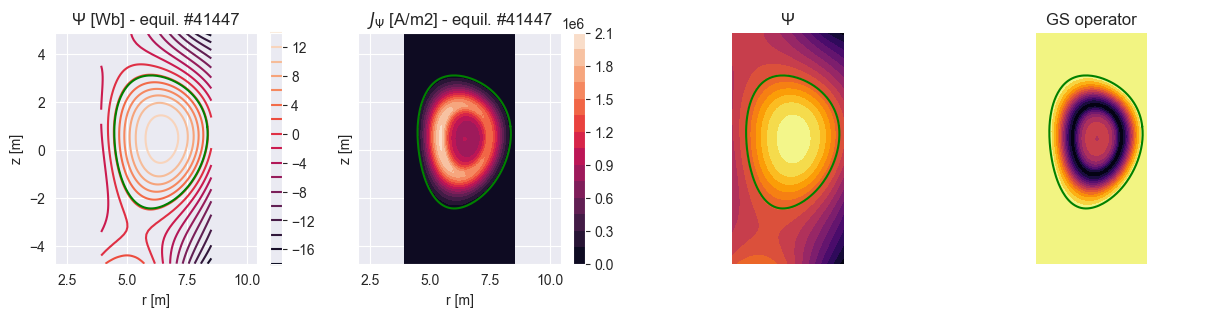

In [7]:
# plot dataset example
cmap = cm.inferno
for i in range(0,1):
    ind_plot = np.random.randint(0,N_ORIG,1)[0]
    fig, axs = plt.subplots(1, 4, figsize=(15, 3), sharey=True)
    ax0 = axs[0].contour(RRf,ZZf,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(ax0)
    axs[0].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0],DB_separatrix_200_test_ConvNet[ind_plot,:,1],c='g')
    axs[0].axis('equal')
    axs[0].set_xlabel('r [m]')
    axs[0].set_ylabel('z [m]')
    axs[0].set_title('Ψ [Wb] - equil. #{}'.format(ind_plot))
    img = axs[1].contourf(RRf,ZZf,DB_Jpla_pixel_test_ConvNet[ind_plot,:,:],15)
    fig.colorbar(img)
    axs[1].axis('equal')
    axs[1].set_title('$J_Ψ$ [A/m2] - equil. #{}'.format(ind_plot))
    axs[1].set_xlabel('r [m]')
    axs[1].set_ylabel('z [m]')
    axs[1].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0],DB_separatrix_200_test_ConvNet[ind_plot,:,1],c='g')

    rm, rM, zm, zM = RRf.min(), RRf.max(), ZZf.min(), ZZf.max()
    img = axs[2].contourf(RRf,ZZf,DB_psi_pixel_test_ConvNet[ind_plot,:,:],15,cmap=cmap)
    axs[2].plot( DB_separatrix_200_test_ConvNet[ind_plot,:,0], DB_separatrix_200_test_ConvNet[ind_plot,:,1], c='g')
    axs[2].set_xlim([rm,rM])
    axs[2].set_ylim([zm,zM])
    axs[2].axis('equal')
    axs[2].set_axis_off()
    axs[2].set_title('Ψ')
    qq = DB_res_RHS_pixel_test_ConvNet[ind_plot,:,:]
    img = axs[3].contourf(RRf,ZZf,qq,15,cmap=cmap)
    axs[3].set_title('GS operator')
    axs[3].axis('equal')
    axs[3].set_xlim([rm,rM])
    axs[3].set_ylim([zm,zM])
    axs[3].axis('equal')
    axs[3].plot(DB_separatrix_200_test_ConvNet[ind_plot,:,0], DB_separatrix_200_test_ConvNet[ind_plot,:,1], c='g')
    axs[3].set_axis_off()

## Interpolation on subgrids

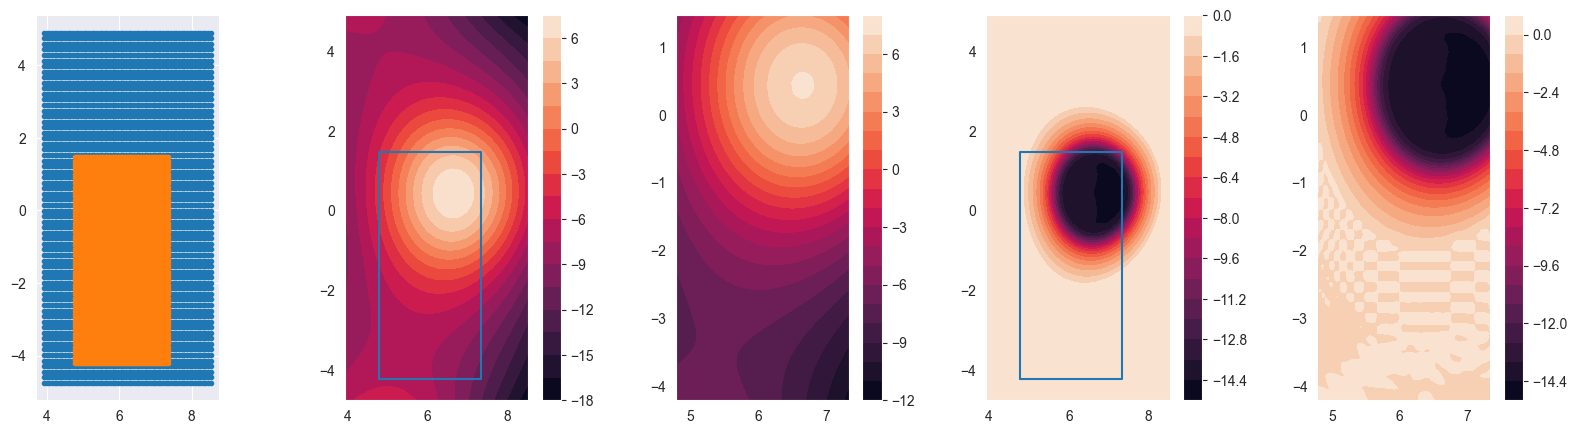

In [8]:
# test interpolation
idx = np.random.randint(0, Y.shape[0], 1)[0]
f, rhs = Y[idx,:,:], DB_res_RHS_pixel_test_ConvNet[idx,:,:]
rrg, zzg = sample_random_subgrid(RRf,ZZf)
box = get_box_from_grid(rrg, zzg)
f_grid = interp_fun(Y[idx,:,:], RRf, ZZf, rrg, zzg)
rhs_grid = interp_fun(rhs, RRf, ZZf, rrg, zzg)

fig,ax = plt.subplots(1,5, figsize=(20,5))
ax[0].scatter(RRf, ZZf, marker='.')
ax[0].scatter(rrg, zzg, marker='.')
ax[0].set_aspect('equal')

im1 = ax[1].contourf(RRf, ZZf, f, 20)
ax[1].plot(box[:,0],box[:,1])
ax[1].set_aspect('equal')

im2 = ax[2].contourf(rrg, zzg, f_grid, 20)
ax[2].set_aspect('equal')

im3 = ax[3].contourf(RRf, ZZf, rhs, 20)
ax[3].set_aspect('equal')
ax[3].plot(box[:,0],box[:,1])

im4 = ax[4].contourf(rrg, zzg, rhs_grid, 20)
ax[4].set_aspect('equal')

plt.colorbar(im1,ax=ax[1])
plt.colorbar(im2,ax=ax[2])
plt.colorbar(im3,ax=ax[3])
plt.colorbar(im4,ax=ax[4])

plt.show()

## Create Dataset

In [9]:
# hyperparameters
N_SAMPLES = 500 # number of samples to use for training
TRAIN_EVAL_SPLIT = 0.8 # percentage of the dataset to use for training
FULL_SUBGRID_SPLIT = 0.5 # percentage of the full grid 
N_GRID = 64 # number of points in the grid

In [10]:
# dataset splitting (N_TOP = original dataset size)
NT = int(N_SAMPLES*TRAIN_EVAL_SPLIT)    # training
NE = N_SAMPLES - NT                     # evaluation
NTF = int(NT*FULL_SUBGRID_SPLIT)        # training full
NTS = NT - NTF                          # training subgrid
NEF = int(NE*FULL_SUBGRID_SPLIT)        # evaluation full
NES = NE - NEF                          # evaluation subgrid 
assert NTF+NTS == NT
assert NEF+NES == NE
assert NTF + NTS + NEF + NES == N_SAMPLES
print(f"Training: {NT}, full: {NTF}, subgrid: {NTS}")
print(f"Eval:     {NE}, full: {NEF}, subgrid: {NES}")
orig_idxs = np.random.permutation(N_ORIG)
orig_idxs_train = orig_idxs[:int(N_ORIG*TRAIN_EVAL_SPLIT)] # original indices for training
orig_idxs_eval = orig_idxs[int(N_ORIG*TRAIN_EVAL_SPLIT):] # original indices for evaluation
# splitting the idxs
idxs_tf = np.random.choice(orig_idxs_train, NTF, replace=False) # training full
idxs_ts = np.random.choice(orig_idxs_train, NTS, replace=False) # can overlap with idxs_tf
idxs_ef = np.random.choice(orig_idxs_eval, NEF, replace=False) # evaluation full
idxs_es = np.random.choice(orig_idxs_eval, NES, replace=False) # can overlap with idxs_ef

Training: 400, full: 200, subgrid: 200
Eval:     100, full: 50, subgrid: 50


In [11]:
# create arrays to store the dataset
x_tf = np.zeros((NTF, *X[0].shape), dtype=DTYPE)
y_tf = np.zeros((NTF, N_GRID, N_GRID), dtype=DTYPE)
rr_tf = np.zeros((NTF, N_GRID, N_GRID), dtype=DTYPE)
zz_tf = np.zeros((NTF, N_GRID, N_GRID), dtype=DTYPE)
rhs_tf = np.zeros((NTF, N_GRID, N_GRID), dtype=DTYPE)

x_ts = np.zeros((NTS, *X[0].shape), dtype=DTYPE)
y_ts = np.zeros((NTS, N_GRID, N_GRID), dtype=DTYPE)
rr_ts = np.zeros((NTS, N_GRID, N_GRID), dtype=DTYPE)
zz_ts = np.zeros((NTS, N_GRID, N_GRID), dtype=DTYPE)
rhs_ts = np.zeros((NTS, N_GRID, N_GRID), dtype=DTYPE)

x_ef = np.zeros((NEF, *X[0].shape), dtype=DTYPE)
y_ef = np.zeros((NEF, N_GRID, N_GRID), dtype=DTYPE)
rr_ef = np.zeros((NEF, N_GRID, N_GRID), dtype=DTYPE)
zz_ef = np.zeros((NEF, N_GRID, N_GRID), dtype=DTYPE)
rhs_ef = np.zeros((NEF, N_GRID, N_GRID), dtype=DTYPE)

x_es = np.zeros((NES, *X[0].shape), dtype=DTYPE)
y_es = np.zeros((NES, N_GRID, N_GRID), dtype=DTYPE)
rr_es = np.zeros((NES, N_GRID, N_GRID), dtype=DTYPE)
zz_es = np.zeros((NES, N_GRID, N_GRID), dtype=DTYPE)
rhs_es = np.zeros((NES, N_GRID, N_GRID), dtype=DTYPE)

## fill the arrays
# Train Full -> just copy the data
x_tf[:], y_tf[:], rhs_tf[:] = X[idxs_tf], Y[idxs_tf], RHS[idxs_tf]
rr_tf[:], zz_tf[:] = RRf, ZZf
# Train Subgrid -> interpolate the data
for i, idx in enumerate(tqdm(idxs_ts)):
    (yi, rhsi), rri, zzi = resample_on_new_subgrid([Y[idx], RHS[idx]], RRf, ZZf, N_GRID, N_GRID)
    y_ts[i], rhs_ts[i], rr_ts[i], zz_ts[i] = yi, rhsi, rri, zzi
x_ts[:] = X[idxs_ts]
# Eval Full -> just copy the data
x_ef[:], y_ef[:], rhs_ef[:] = X[idxs_ef], Y[idxs_ef], RHS[idxs_ef]
rr_ef[:], zz_ef[:] = RRf, ZZf
# Eval Subgrid -> interpolate the data
for i, idx in enumerate(tqdm(idxs_es)):
    (yi, rhsi), rri, zzi = resample_on_new_subgrid([Y[idx], RHS[idx]], RRf, ZZf, N_GRID, N_GRID)
    y_es[i], rhs_es[i], rr_es[i], zz_es[i] = yi, rhsi, rri, zzi
x_es[:] = X[idxs_es]

# concatenate the arrays
x_train = np.concatenate((x_tf, x_ts))
y_train = np.concatenate((y_tf, y_ts))
rr_train = np.concatenate((rr_tf, rr_ts))
zz_train = np.concatenate((zz_tf, zz_ts))
rhs_train = np.concatenate((rhs_tf, rhs_ts))
del x_tf, y_tf, rr_tf, zz_tf, rhs_tf, x_ts, y_ts, rr_ts, zz_ts, rhs_ts

x_eval = np.concatenate((x_ef, x_es))
y_eval = np.concatenate((y_ef, y_es))
rr_eval = np.concatenate((rr_ef, rr_es))
zz_eval = np.concatenate((zz_ef, zz_es))
rhs_eval = np.concatenate((rhs_ef, rhs_es))
del x_ef, y_ef, rr_ef, zz_ef, rhs_ef, x_es, y_es, rr_es, zz_es, rhs_es
print(f"x_train: {x_train.shape}, y_train: {y_train.shape}, rr_train: {rr_train.shape}, zz_train: {zz_train.shape}, rhs_train: {rhs_train.shape}")
print(f"x_eval: {x_eval.shape}, y_eval: {y_eval.shape}, rr_eval: {rr_eval.shape}, zz_eval: {zz_eval.shape}, rhs_eval: {rhs_eval.shape}")


100%|██████████| 50/50 [00:01<00:00, 48.71it/s]

x_train: (400, 201), y_train: (400, 64, 64), rr_train: (400, 64, 64), zz_train: (400, 64, 64), rhs_train: (400, 64, 64)
x_eval: (100, 201), y_eval: (100, 64, 64), rr_eval: (100, 64, 64), zz_eval: (100, 64, 64), rhs_eval: (100, 64, 64)


In [12]:
# calculate kernels for Grad-Shafranov equation #TODO: double check this
# so we don't have to do it during training
laplace_ker_t = np.zeros((len(x_train), 3, 3), dtype=DTYPE)
laplace_ker_e = np.zeros((len(x_eval), 3, 3), dtype=DTYPE)
df_dr_ker_t = np.zeros((len(x_train), 3, 3), dtype=DTYPE)
df_dr_ker_e = np.zeros((len(x_eval), 3, 3), dtype=DTYPE)
hrs_t, hzs_t = rr_train[:,1,2]-rr_train[:,1,1], zz_train[:,2,1]-zz_train[:,1,1]
hrs_e, hzs_e = rr_eval[:,1,2]-rr_eval[:,1,1], zz_eval[:,2,1]-zz_eval[:,1,1]
for i in range(len(x_train)):
    laplace_ker_t[i,:,:], df_dr_ker_t[i,:,:] = calc_laplace_df_dr_ker(hrs_t[i], hzs_t[i])
for i in range(len(x_eval)):
    laplace_ker_e[i,:,:], df_dr_ker_e[i,:,:] = calc_laplace_df_dr_ker(hrs_e[i], hzs_e[i])

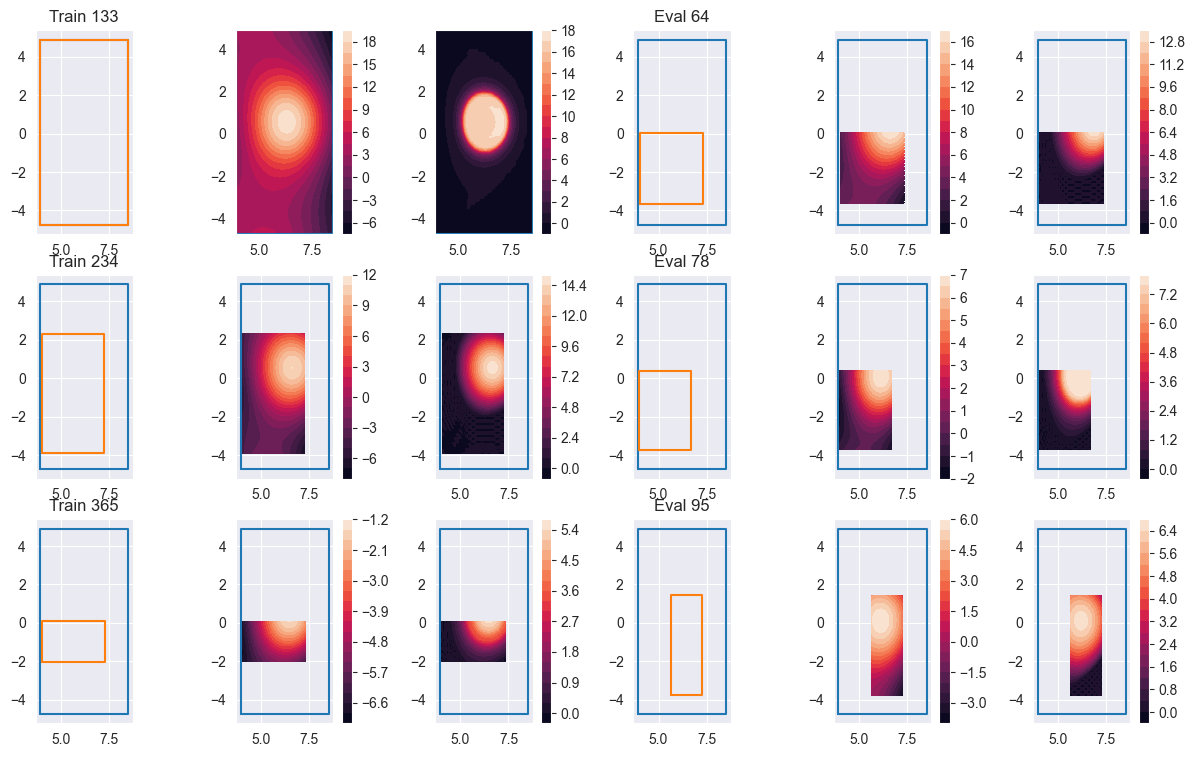

In [13]:
# check the dataset
rows = 3
idxs_train = np.random.randint(0, len(x_train), rows)
idxs_eval = np.random.randint(0, len(x_eval), rows)
fig,ax = plt.subplots(rows,6, figsize=(15,3*rows))
box0 = get_box_from_grid(RRf, ZZf)
for i, (it, ie)  in enumerate(zip(idxs_train, idxs_eval)):
    # training
    boxi = get_box_from_grid(rr_train[it], zz_train[it])
    ax[i,0].plot(box0[:,0], box0[:,1])
    ax[i,0].plot(boxi[:,0], boxi[:,1])
    ax[i,0].set_aspect('equal')
    ax[i,0].set_title(f"Train {it}")
    a1 = ax[i,1].contourf(rr_train[it], zz_train[it], y_train[it], 20)
    ax[i,1].plot(box0[:,0], box0[:,1])
    ax[i,1].set_aspect('equal')
    plt.colorbar(a1,ax=ax[i,1])
    a2 = ax[i,2].contourf(rr_train[it], zz_train[it] ,-rhs_train[it], 20)
    ax[i,2].plot(box0[:,0], box0[:,1])
    ax[i,2].set_aspect('equal')
    plt.colorbar(a2,ax=ax[i,2])
    # evaluation
    boxi = get_box_from_grid(rr_eval[ie], zz_eval[ie])
    ax[i,3].plot(box0[:,0], box0[:,1])
    ax[i,3].plot(boxi[:,0], boxi[:,1])
    ax[i,3].set_aspect('equal')
    ax[i,3].set_title(f"Eval {ie}")
    a1 = ax[i,4].contourf(rr_eval[ie], zz_eval[ie], y_eval[ie], 20)
    ax[i,4].plot(box0[:,0], box0[:,1])
    ax[i,4].set_aspect('equal')
    plt.colorbar(a1,ax=ax[i,4])
    a2 = ax[i,5].contourf(rr_eval[ie], zz_eval[ie] ,-rhs_eval[ie], 20)
    ax[i,5].plot(box0[:,0], box0[:,1])
    ax[i,5].set_aspect('equal')
    plt.colorbar(a2,ax=ax[i,5])
plt.show()

## Calculating Grad-Shafranov Operator with convolutions

In [14]:
def plot_gso_test():
    idx = np.random.randint(0, len(x_train), 1)[0]
    psi, rhs = y_train[idx], rhs_train[idx]
    rr, zz = rr_train[idx], zz_train[idx]
    big_box = get_box_from_grid(RRf, ZZf)
    box = get_box_from_grid(rr, zz)

    gso = calc_gso(psi, rr, zz)

    fig,ax = plt.subplots(1,5, figsize=(20,5))
    ax[0].plot(big_box[:,0], big_box[:,1])
    ax[0].plot(box[:,0], box[:,1])
    ax[0].set_aspect('equal')
    ax[0].set_xticks([]), ax[0].set_yticks([])

    im1 = ax[1].contourf(rr, zz, psi, 20)
    ax[1].plot(big_box[:,0], big_box[:,1])
    ax[1].set_aspect('equal')
    ax[1].set_xticks([]), ax[1].set_yticks([])

    im2 = ax[2].contourf(rr, zz, -gso, 20)
    ax[2].plot(big_box[:,0], big_box[:,1])
    ax[2].set_aspect('equal')
    ax[2].set_xticks([]), ax[2].set_yticks([])

    im3 = ax[3].contourf(rr, zz, -rhs, 20)
    ax[3].plot(big_box[:,0], big_box[:,1])
    ax[3].set_aspect('equal')
    ax[3].set_xticks([]), ax[3].set_yticks([])

    im4 = ax[4].contourf(rr, zz, np.abs(gso-rhs), 20)
    ax[4].plot(big_box[:,0], big_box[:,1])
    ax[4].set_aspect('equal')
    ax[4].set_xticks([]), ax[4].set_yticks([])

    plt.colorbar(im1,ax=ax[1])
    plt.colorbar(im2,ax=ax[2])
    plt.colorbar(im3,ax=ax[3])
    plt.colorbar(im4,ax=ax[4])

    plt.show()

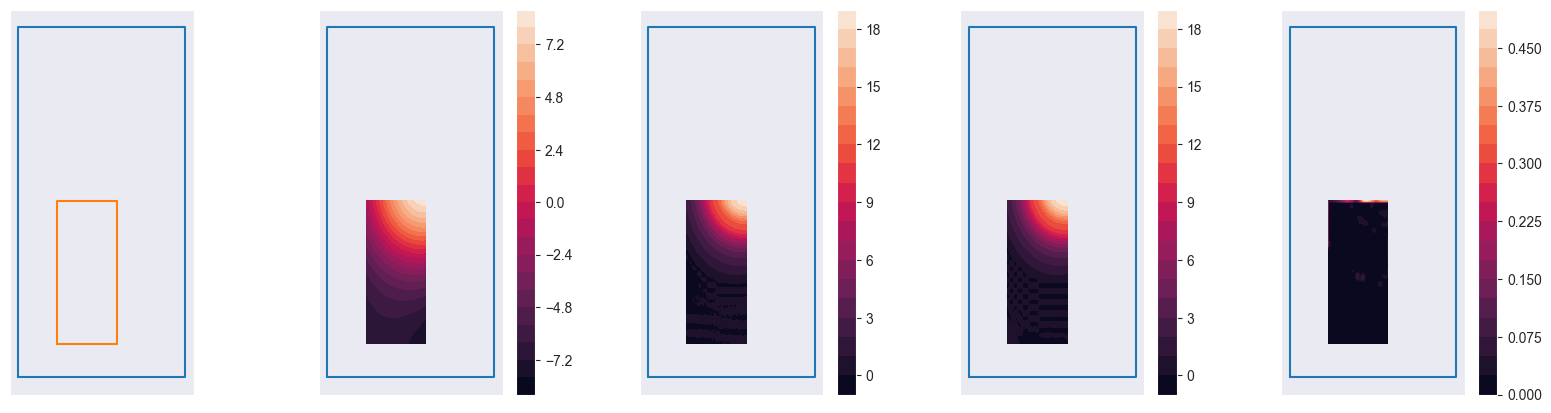

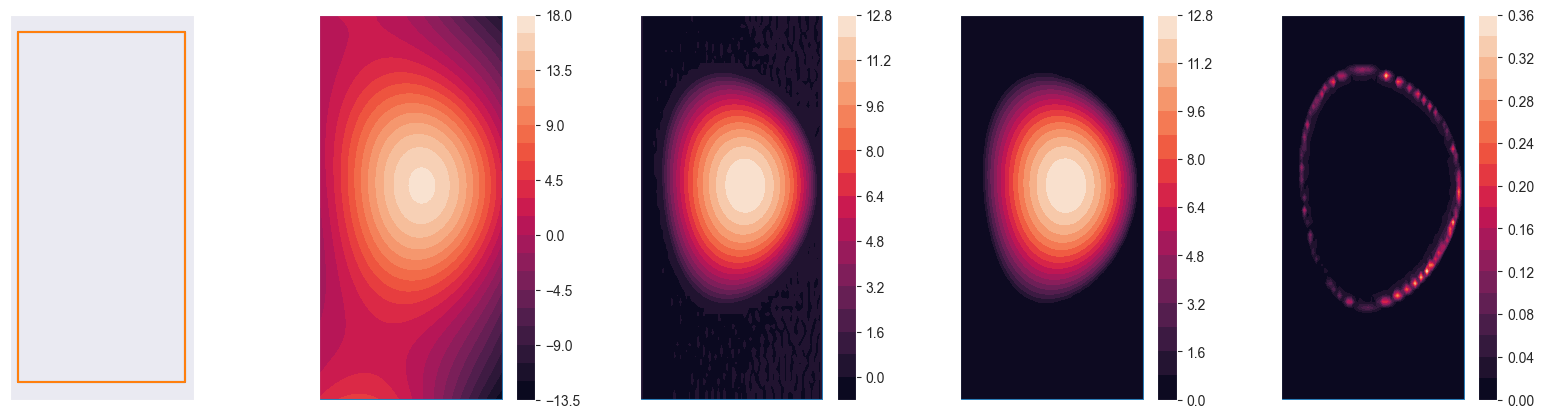

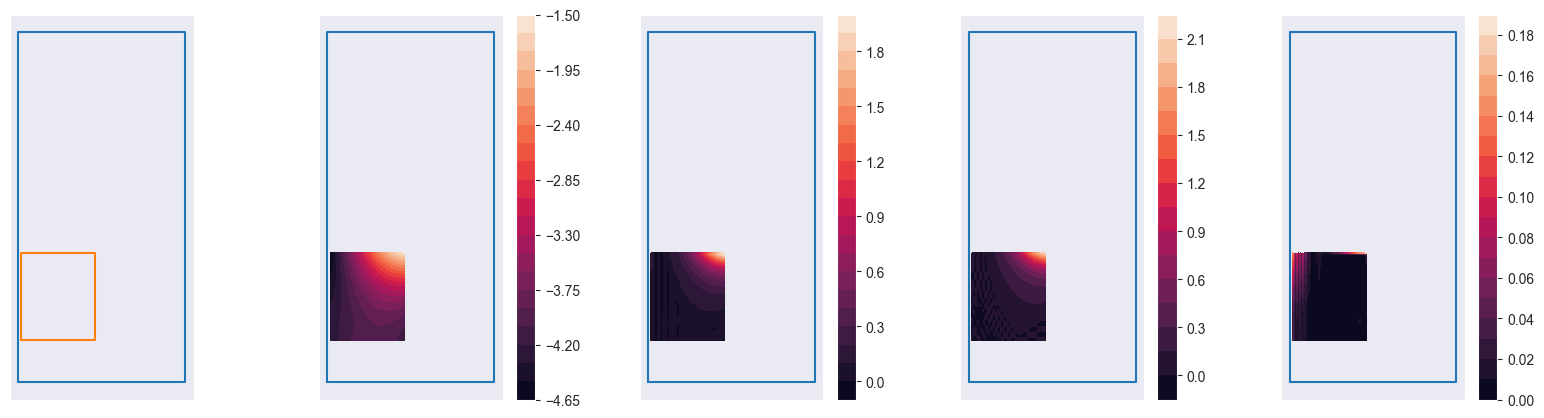

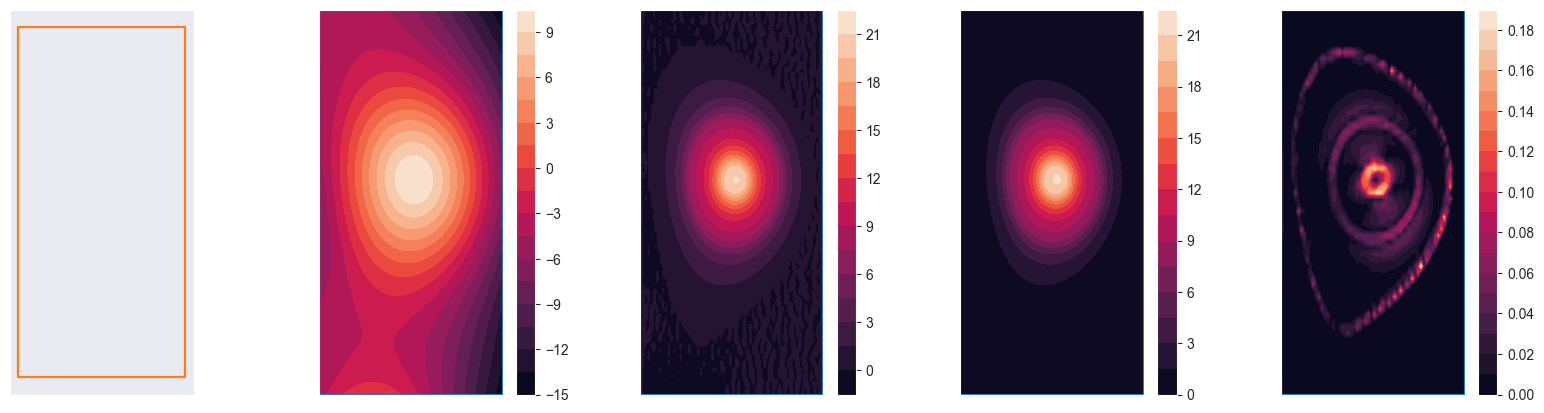

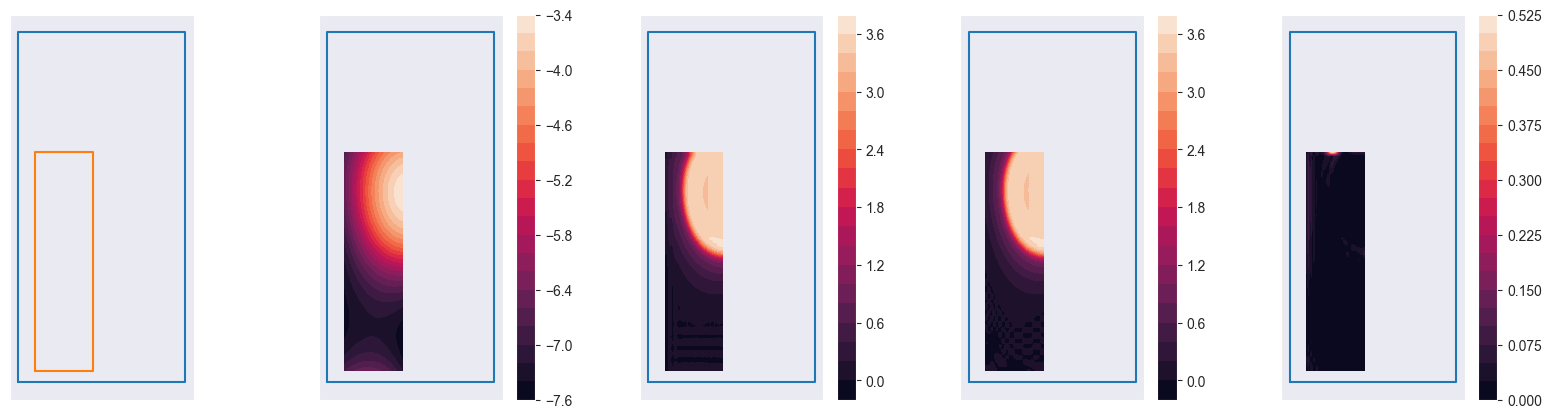

In [18]:
import torch
import torch.nn.functional as F
def calc_gso(ψ, rr, zz):
    assert ψ.shape == (64,64), f"ψ.shape = {ψ.shape}"
    assert rr.shape == (64,64), f"rr.shape = {rr.shape}"
    assert zz.shape == (64,64), f"zz.shape = {zz.shape}"
    ψ, rr, zz = map(torch.tensor, (ψ, rr, zz)) # convert to tensors
    Δr, Δz = rr[1,2]-rr[1,1], zz[2,1]-zz[1,1] 
    α = -2*(Δr**2 + Δz**2)  # constant
    β = (Δr**2 * Δz**2) / α # constant
    lap_ker = torch.tensor([[0, Δr**2/α, 0], [Δz**2/α, 1, Δz**2/α], [0, Δr**2/α, 0]], dtype=torch.float32)
    dr_ker = torch.tensor([[0,0,0],[-1,0,+1],[0,0,0]], dtype=torch.float32) * (Δr**2 * Δz**2) / (2*Δr*α)
    gauss_ker = torch.tensor([[1,2,1],[2,4,2],[1,2,1]], dtype=torch.float32) / 16
    Ψ = F.conv2d(F.pad(ψ.view(1,1,64,64), (1,1,1,1), mode='replicate'), gauss_ker.view(1,1,3,3), padding=0) # smoothing
    conv_lap = F.conv2d(ψ.view(1,1,64,64), lap_ker.view(1,1,3,3), padding=0) # laplacian through convolution
    conv_lap = F.pad(conv_lap, (1,1,1,1), mode='replicate') # pad the result to keep the same shape
    conv_dr = F.conv2d(ψ.view(1,1,64,64), dr_ker.view(1,1,3,3), padding=0) # dψ/dr through convolution
    conv_dr = F.pad(conv_dr, (1,1,1,1), mode='replicate') # pad the result to keep the same shape
    print
    ΔΨ = (1/β) * (conv_lap - conv_dr/rr.view(1,1,64,64)) # grad-shafranov operator
    return (ΔΨ.view(64,64)).numpy()

for _ in range(5): plot_gso_test()

In [16]:
assert False

AssertionError: 

## Export dataset Tensorflow

In [14]:
import tensorflow as tf
train_ds_tf = tf.data.Dataset.from_tensor_slices((x_train, y_train, rhs_train[:,1:-1,1:-1], rr_train, zz_train, laplace_ker_t, df_dr_ker_t))
eval_ds_tf = tf.data.Dataset.from_tensor_slices((x_eval, y_eval, rhs_eval[:,1:-1,1:-1], rr_eval, zz_eval, laplace_ker_e, df_dr_ker_e))
# save the datasets
tf.data.Dataset.save(train_ds_tf, join(DATA_DIR, 'train_ds_tf'))
tf.data.Dataset.save(eval_ds_tf, join(DATA_DIR, 'eval_ds_tf'))

In [ ]:
# test loading the datasets
del train_ds_tf, eval_ds_tf
train_ds_tf = tf.data.Dataset.load(join(DATA_DIR, 'train_ds_tf'))
eval_ds_tf = tf.data.Dataset.load(join(DATA_DIR, 'eval_ds_tf'))
#shuffle and batch the datasets
train_ds_tf = train_ds_tf.shuffle(len(x_train)).batch(32)
eval_ds_tf = eval_ds_tf.shuffle(len(x_eval)).batch(32)
print(train_ds_tf.element_spec)
print(eval_ds_tf.element_spec)
print(f"Training dataset size: {len(train_ds_tf)}")
print(f"Eval dataset size: {len(eval_ds_tf)}")

## Export dataset Pytorch

In [ ]:
raise NotImplementedError